In [31]:
import requests
import pandas as pd
import tqdm
import bs4
import json
import matplotlib.pyplot as plt
from adjustText import adjust_text
from pathlib import Path
import time
import great_tables as gt

In [7]:
from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs

In [8]:
reverse_type_map = {1: 'Jump Shot',
 79: 'Pullup Jump shot',
 52: 'Alley Oop Dunk Shot',
 3: 'Hook Shot',
 80: 'Step Back Jump shot',
 47: 'Turnaround Jump Shot',
 5: 'Layup Shot',
 103: 'Running Pull-Up Jump Shot',
 6: 'Driving Layup Shot',
 50: 'Running Dunk Shot',
 108: 'Cutting Dunk Shot',
 43: 'Alley Oop Layup shot',
 101: 'Driving Floating Jump Shot',
 2: 'Running Jump Shot',
 86: 'Turnaround Fadeaway shot',
 63: 'Fadeaway Jump Shot',
 78: 'Floating Jump shot',
 98: 'Cutting Layup Shot',
 41: 'Running Layup Shot',
 7: 'Dunk Shot',
 9: 'Driving Dunk Shot',
 99: 'Cutting Finger Roll Layup Shot',
 76: 'Running Finger Roll Layup Shot',
 58: 'Turnaround Hook Shot',
 106: 'Running Alley Oop Dunk Shot',
 102: 'Driving Floating Bank Jump Shot',
 100: 'Running Alley Oop Layup Shot',
 73: 'Driving Reverse Layup Shot',
 105: 'Turnaround Fadeaway Bank Jump Shot',
 75: 'Driving Finger Roll Layup Shot',
 44: 'Reverse Layup Shot',
 74: 'Running Reverse Layup Shot',
 66: 'Jump Bank Shot',
 57: 'Driving Hook Shot',
 67: 'Hook Bank Shot',
 71: 'Finger Roll Layup Shot',
 93: 'Driving Bank Hook Shot',
 51: 'Reverse Dunk Shot',
 110: 'Running Reverse Dunk Shot',
 104: 'Step Back Bank Jump Shot',
 109: 'Driving Reverse Dunk Shot',
 96: 'Turnaround Bank Hook Shot',
 8: 'Slam Dunk Shot',
 42: 'Driving Layup Shot',
 4: 'Tip Shot',
 65: 'Jump Hook Shot',
 46: 'Running Jump Shot',
 49: 'Driving Dunk Shot',
 56: 'Running Hook Shot',
 64: 'Follow Up Dunk Shot',
 59: 'Finger Roll Shot',
 61: 'Driving Finger Roll Shot',
 60: 'Running Finger Roll Shot',
 62: 'Turnaround Finger Roll Shot',
 54: 'Running Tip Shot',
 53: 'Tip Shot',
 45: 'Jump Shot',
 40: 'Layup Shot',
 48: 'Dunk Shot',
 55: 'Hook Shot',
 85: 'Turnaround Bank shot',
 87: 'Putback Dunk Shot',
 77: 'Driving Jump shot',
 72: 'Putback Layup Shot',
 90: 'Running Slam Dunk Shot',
 88: 'Driving Slam Dunk Shot',
 92: 'Putback Slam Dunk Shot',
 83: 'Fadeaway Bank shot',
 95: 'Running Bank Hook Shot',
 84: 'Running Bank shot',
 89: 'Reverse Slam Dunk Shot',
 82: 'Driving Bank shot',
 81: 'Pullup Bank shot',
 91: 'Putback Reverse Dunk Shot',
 94: 'Jump Bank Hook Shot',
                   }

In [9]:
full_df = pd.read_csv('pbp_data/2023-24.csv')

full_df = full_df.fillna({
    "HOMEDESCRIPTION": "",
    "NEUTRALDESCRIPTION": "",
    "VISITORDESCRIPTION": ""
})
full_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in full_df.GAME_ID.astype(str)]

In [10]:
shots_made = full_df.loc[full_df.EVENTMSGTYPE == 1]

In [11]:
assists = shots_made.loc[shots_made.PLAYER2_ID != 0]

In [12]:
assist_counts = assists.groupby(['PLAYER1_ID', 'PLAYER2_ID', 'PLAYER1_NAME', 'PLAYER2_NAME']).size().to_frame().reset_index()

assist_counts = assist_counts.rename(columns={0: 'COUNT'})

top_assisters = assist_counts.sort_values(by='COUNT', ascending=False).reset_index().iloc[:30]

In [13]:
top_assisters

index  PLAYER1_ID  PLAYER2_ID              PLAYER1_NAME  \
0    2551     1630578     1627832            Alperen Sengun   
1     643      203954     1630178               Joel Embiid   
2     785     1626167     1630169              Myles Turner   
3    1486     1629008      203999        Michael Porter Jr.   
4     672      203992     1629027         Bogdan Bogdanovic   
5     442      203484      203999  Kentavious Caldwell-Pope   
6    2004     1630167     1630169                Obi Toppin   
7     740     1626157      201144        Karl-Anthony Towns   
8       1        2544     1626156              LeBron James   
9     960     1627751      203471              Jakob Poeltl   
10    328      203076        2544             Anthony Davis   
11   1010     1627783      203471             Pascal Siakam   
12    329      203076     1626156             Anthony Davis   
13   1412     1628989     1627734             Kevin Huerter   
14   2377     1630532     1631094              Franz Wagner   
15    620      203944     1628973             Julius Randle   
16   2464     1630552     1629027             Jalen Johnson   
17    502      203507      203081     Giannis Antetokounmpo   
18   1362     1628973      203944             Jalen Brunson   
19    242      202691      101108             Klay Thompson   
20      8        2544     1630559              LeBron James   
21    559      203924     1627763              Jerami Grant   
22   1167     1628384      203471                OG Anunoby   
23    286      202696     1629632            Nikola Vucevic   
24   2089     1630178      203954              Tyrese Maxey   
25    304      202704      203999            Reggie Jackson   
26   1207     1628398     1626145                Kyle Kuzma   
27    653      203967      101108               Dario Saric   
28   2745     1631096     1628983             Chet Holmgren   
29    918     1627741     1630169               Buddy Hield   

               PLAYER2_NAME  COUNT  
0             Fred VanVleet     55  
1              Tyrese Maxey     47  
2         Tyrese Haliburton     46  
3              Nikola Jokic     41  
4                Trae Young     38  
5              Nikola Jokic     38  
6         Tyrese Haliburton     36  
7               Mike Conley     36  
8          D'Angelo Russell     35  
9           Dennis Schroder     34  
10             LeBron James     33  
11          Dennis Schroder     33  
12         D'Angelo Russell     33  
13         Domantas Sabonis     33  
14           Paolo Banchero     32  
15            Jalen Brunson     32  
16               Trae Young     31  
17           Damian Lillard     31  
18            Julius Randle     31  
19               Chris Paul     31  
20            Austin Reaves     31  
21          Malcolm Brogdon     30  
22          Dennis Schroder     29  
23               Coby White     29  
24              Joel Embiid     29  
25             Nikola Jokic     29  
26               Tyus Jones     28  
27               Chris Paul     28  
28  Shai Gilgeous-Alexander     28  
29        Tyrese Haliburton     28

In [14]:
alley_oop_types = [43, 52, 106, 100]

In [15]:
alley_oops = assists.loc[assists.EVENTMSGACTIONTYPE.isin(alley_oop_types)]

In [16]:
oop_counts = alley_oops.groupby(['PLAYER1_NAME', 'PLAYER1_ID', 'PLAYER2_NAME', 'PLAYER2_ID']).size().to_frame().reset_index().rename(columns={0: 'COUNT'})

In [17]:
top_alley_oopers = oop_counts.sort_values(by='COUNT', ascending=False).iloc[:15]

In [18]:
top_alley_oopers

PLAYER1_NAME  PLAYER1_ID        PLAYER2_NAME  PLAYER2_ID  COUNT
75        Dereck Lively II     1641726         Luka Doncic     1629029     11
268            Rudy Gobert      203497         Mike Conley      201144     10
52            Clint Capela      203991          Trae Young     1629027      8
230            Nic Claxton     1629651   Spencer Dinwiddie      203915      8
118           JaVale McGee      201580          Malik Monk     1628370      8
266            Rudy Gobert      203497  Karl-Anthony Towns     1626157      8
241             Obi Toppin     1630167   Tyrese Haliburton     1630169      8
18           Anthony Davis      203076        LeBron James        2544      8
297      Victor Wembanyama     1641705           Tre Jones     1630200      7
3             Aaron Gordon      203932        Nikola Jokic      203999      7
201          Mark Williams     1631109         LaMelo Ball     1630163      7
249         Onyeka Okongwu     1630168          Trae Young     1629027      7
141          Jarrett Allen     1628386      Darius Garland     1629636      7
179     Kristaps Porzingis      204001        Jaylen Brown     1627759      6
99   Giannis Antetokounmpo      203507     Khris Middleton      203114      6

In [19]:
oop_assisters = alley_oops.groupby('PLAYER2_NAME').size().to_frame().reset_index().rename(columns={0: 'COUNT'})

In [20]:
oop_assisters.sort_values(by='COUNT', ascending=False)

PLAYER2_NAME  COUNT
113        LaMelo Ball     23
161         Trae Young     20
35      Darius Garland     15
116        Luka Doncic     15
152  Spencer Dinwiddie     12
..                 ...    ...
46        Devin Booker      1
129       Myles Turner      1
45        Desmond Bane      1
132         Obi Toppin      1
130      Nassir Little      1

[171 rows x 2 columns]

## Plotting alley ooper table

In [21]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
zoom = 0.63
team_root_dir = '../../team_logos_id/'
player_root_dir = f'player_imgs/'

def get_player_img(player_id, zoom=zoom):
    #print(path)
    return OffsetImage(plt.imread(f'{player_root_dir}{player_id}.png'), zoom=zoom)

def get_team_img(team_id):
    #print(path)
    return OffsetImage(plt.imread(f'{team_root_dir}{team_id}.png'), zoom=zoom)

In [22]:
plt.style.use('fivethirtyeight')

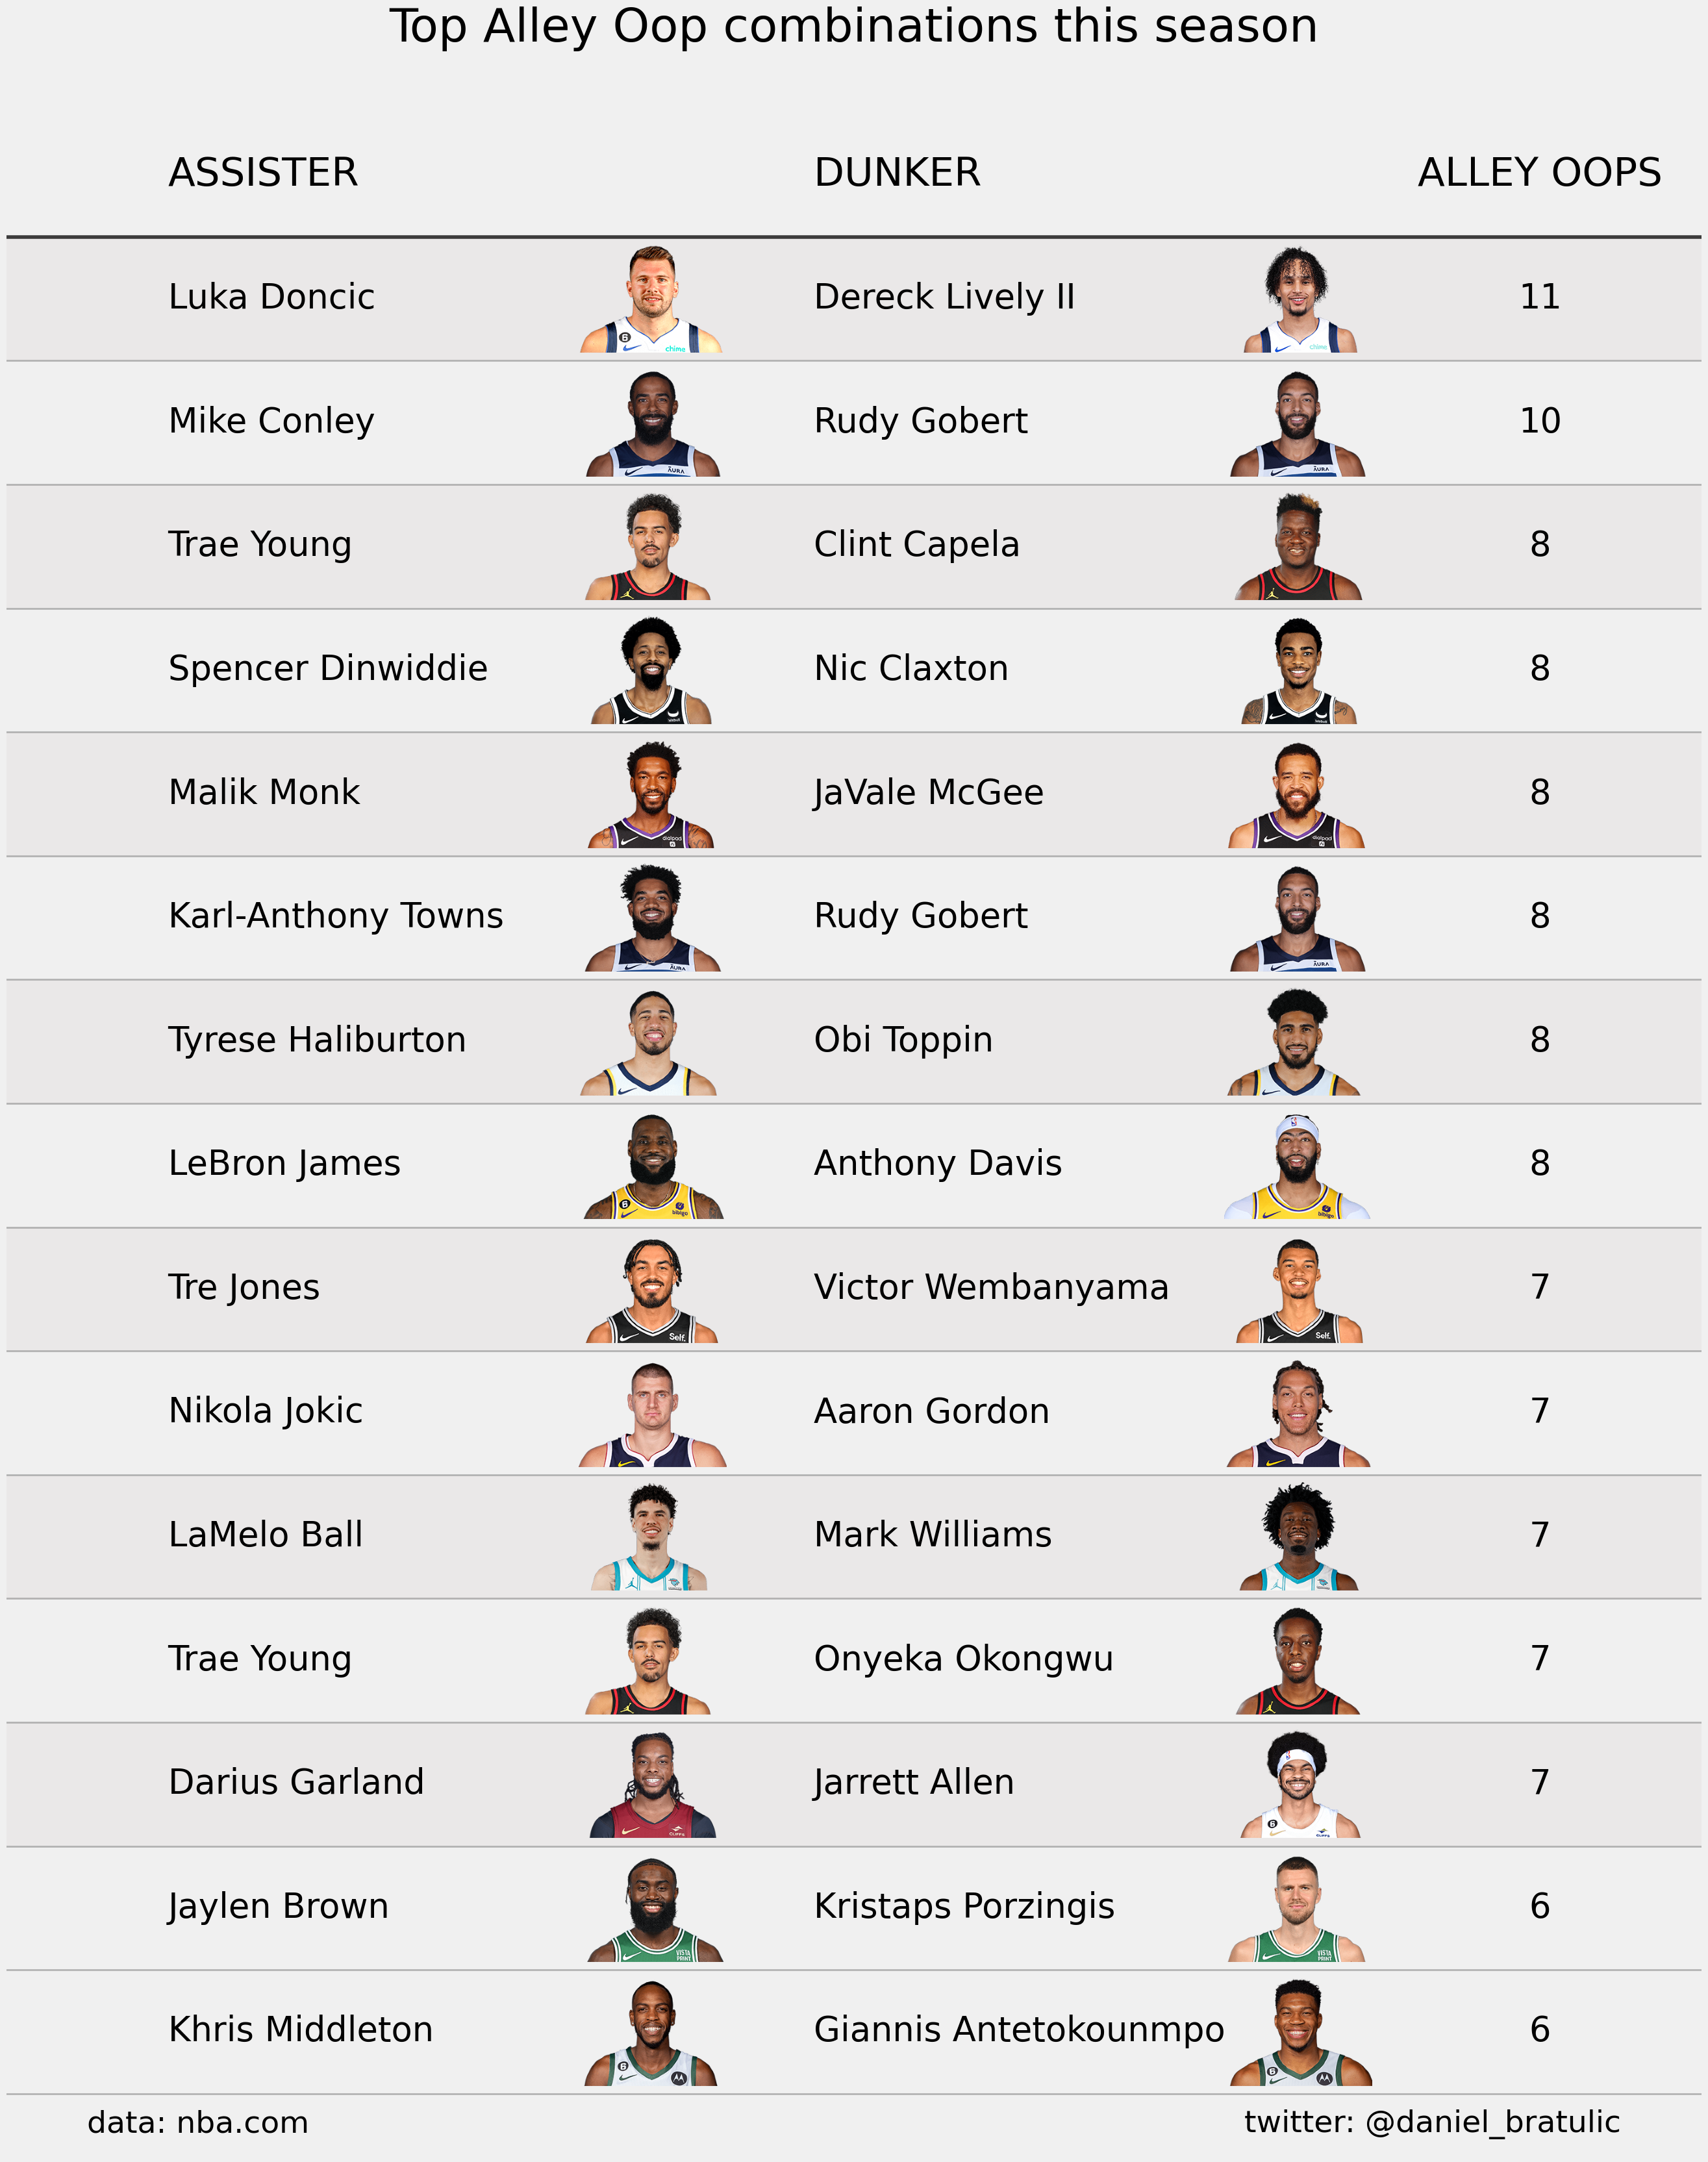

In [23]:
fig, ax = plt.subplots(figsize=(30, 40))
font_size = 38
font_title = 44
top = len(top_alley_oopers)
#top = 10


for i in range(top):
    item = top_alley_oopers.iloc[i]
    y_coord = top - i - 1
    if i % 2 == 1:
        color = '#EAE8E8'
        rect = Rectangle((-4.5, y_coord + 0.5), width=15, height=1, fill=True, color=color)
        ax.add_patch(rect)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=10, color='#A0A0A0', alpha=0.75, lw=2)
    ab = AnnotationBbox(get_player_img(item.PLAYER2_ID), (0.4, y_coord), frameon=False)
    ax.add_artist(ab)
    ax.text(x=0.1, y=y_coord, ha='left', va='center', s=item.PLAYER2_NAME, size=font_size)
    
    ab = AnnotationBbox(get_player_img(item.PLAYER1_ID), (0.8, y_coord), frameon=False)
    ax.add_artist(ab)
    ax.text(x=0.5, y=y_coord, ha='left', va='center', s=item.PLAYER1_NAME, size=font_size)
    ax.text(x=0.95, y=y_coord, ha='center', va='center', s=f"{item.COUNT}", size=font_size)
    #ax.text(x=2.2, y=y_coord, ha='center', va='center', s=f"{item.OPP_WIDE_OPEN_FG3_PCT:.2f}%", size=font_size)
    #ax.text(x=2.7, y=y_coord, ha='center', va='center', s=f"{item.DIFF:.2f}%", size=font_size)
    

    #ax.imshow(player_imgs[item.PLAYER_ID], extent=(0, 0.3, y_coord-0.5,y_coord + 0.5), aspect='auto', zorder=1)
    #ax.imshow(team_imgs[item.TEAM_ID], extent=(0.27, 0.38, y_coord-0.5,y_coord + 0.5), aspect='auto', zorder=1)
    
    
    #y_img_start = y_coord-0.5 + (1 - 0.730769232) / 2
    #ax.imshow(img, extent=(0, 1.36, y_img_start-0.5, y_img_start + 0.1), aspect='auto')
    #ax.imshow(img, extent=(0, 260, 0, 190), aspect=260/190)
    
ax.text(x=0.1, y=top, s='ASSISTER', ha='left', va='center', size=font_title)
ax.text(x=0.5, y=top, ha='left', va='center', s="DUNKER", size=font_title)
ax.text(x=0.95, y=top, ha='center', va='center', s="ALLEY OOPS", size=font_title)
#ax.text(x=2.7, y=top, ha='center', va='center', s="DIFF", size=font_title)

ax.text(x=1.0, y=-0.75, s='twitter: @daniel_bratulic', ha='right', va='center', size=34)
ax.text(x=0.05, y=-0.75, s='data: nba.com', ha='left', va='center', size=34)
ax.axhline(y=top-0.5, xmin=-0.25, xmax=10, color='black', alpha=0.75, lw=4)
ax.set_title("Top Alley Oop combinations this season", size=52)
    
ax.set_ylim(bottom=-1, top=top+1)
ax.set_xlim(left=-0, right=1.05)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.savefig('table_dunkers.png', dpi=120, bbox_inches='tight')

## Assist combos

In [24]:
top_assist = top_assisters.iloc[:19]

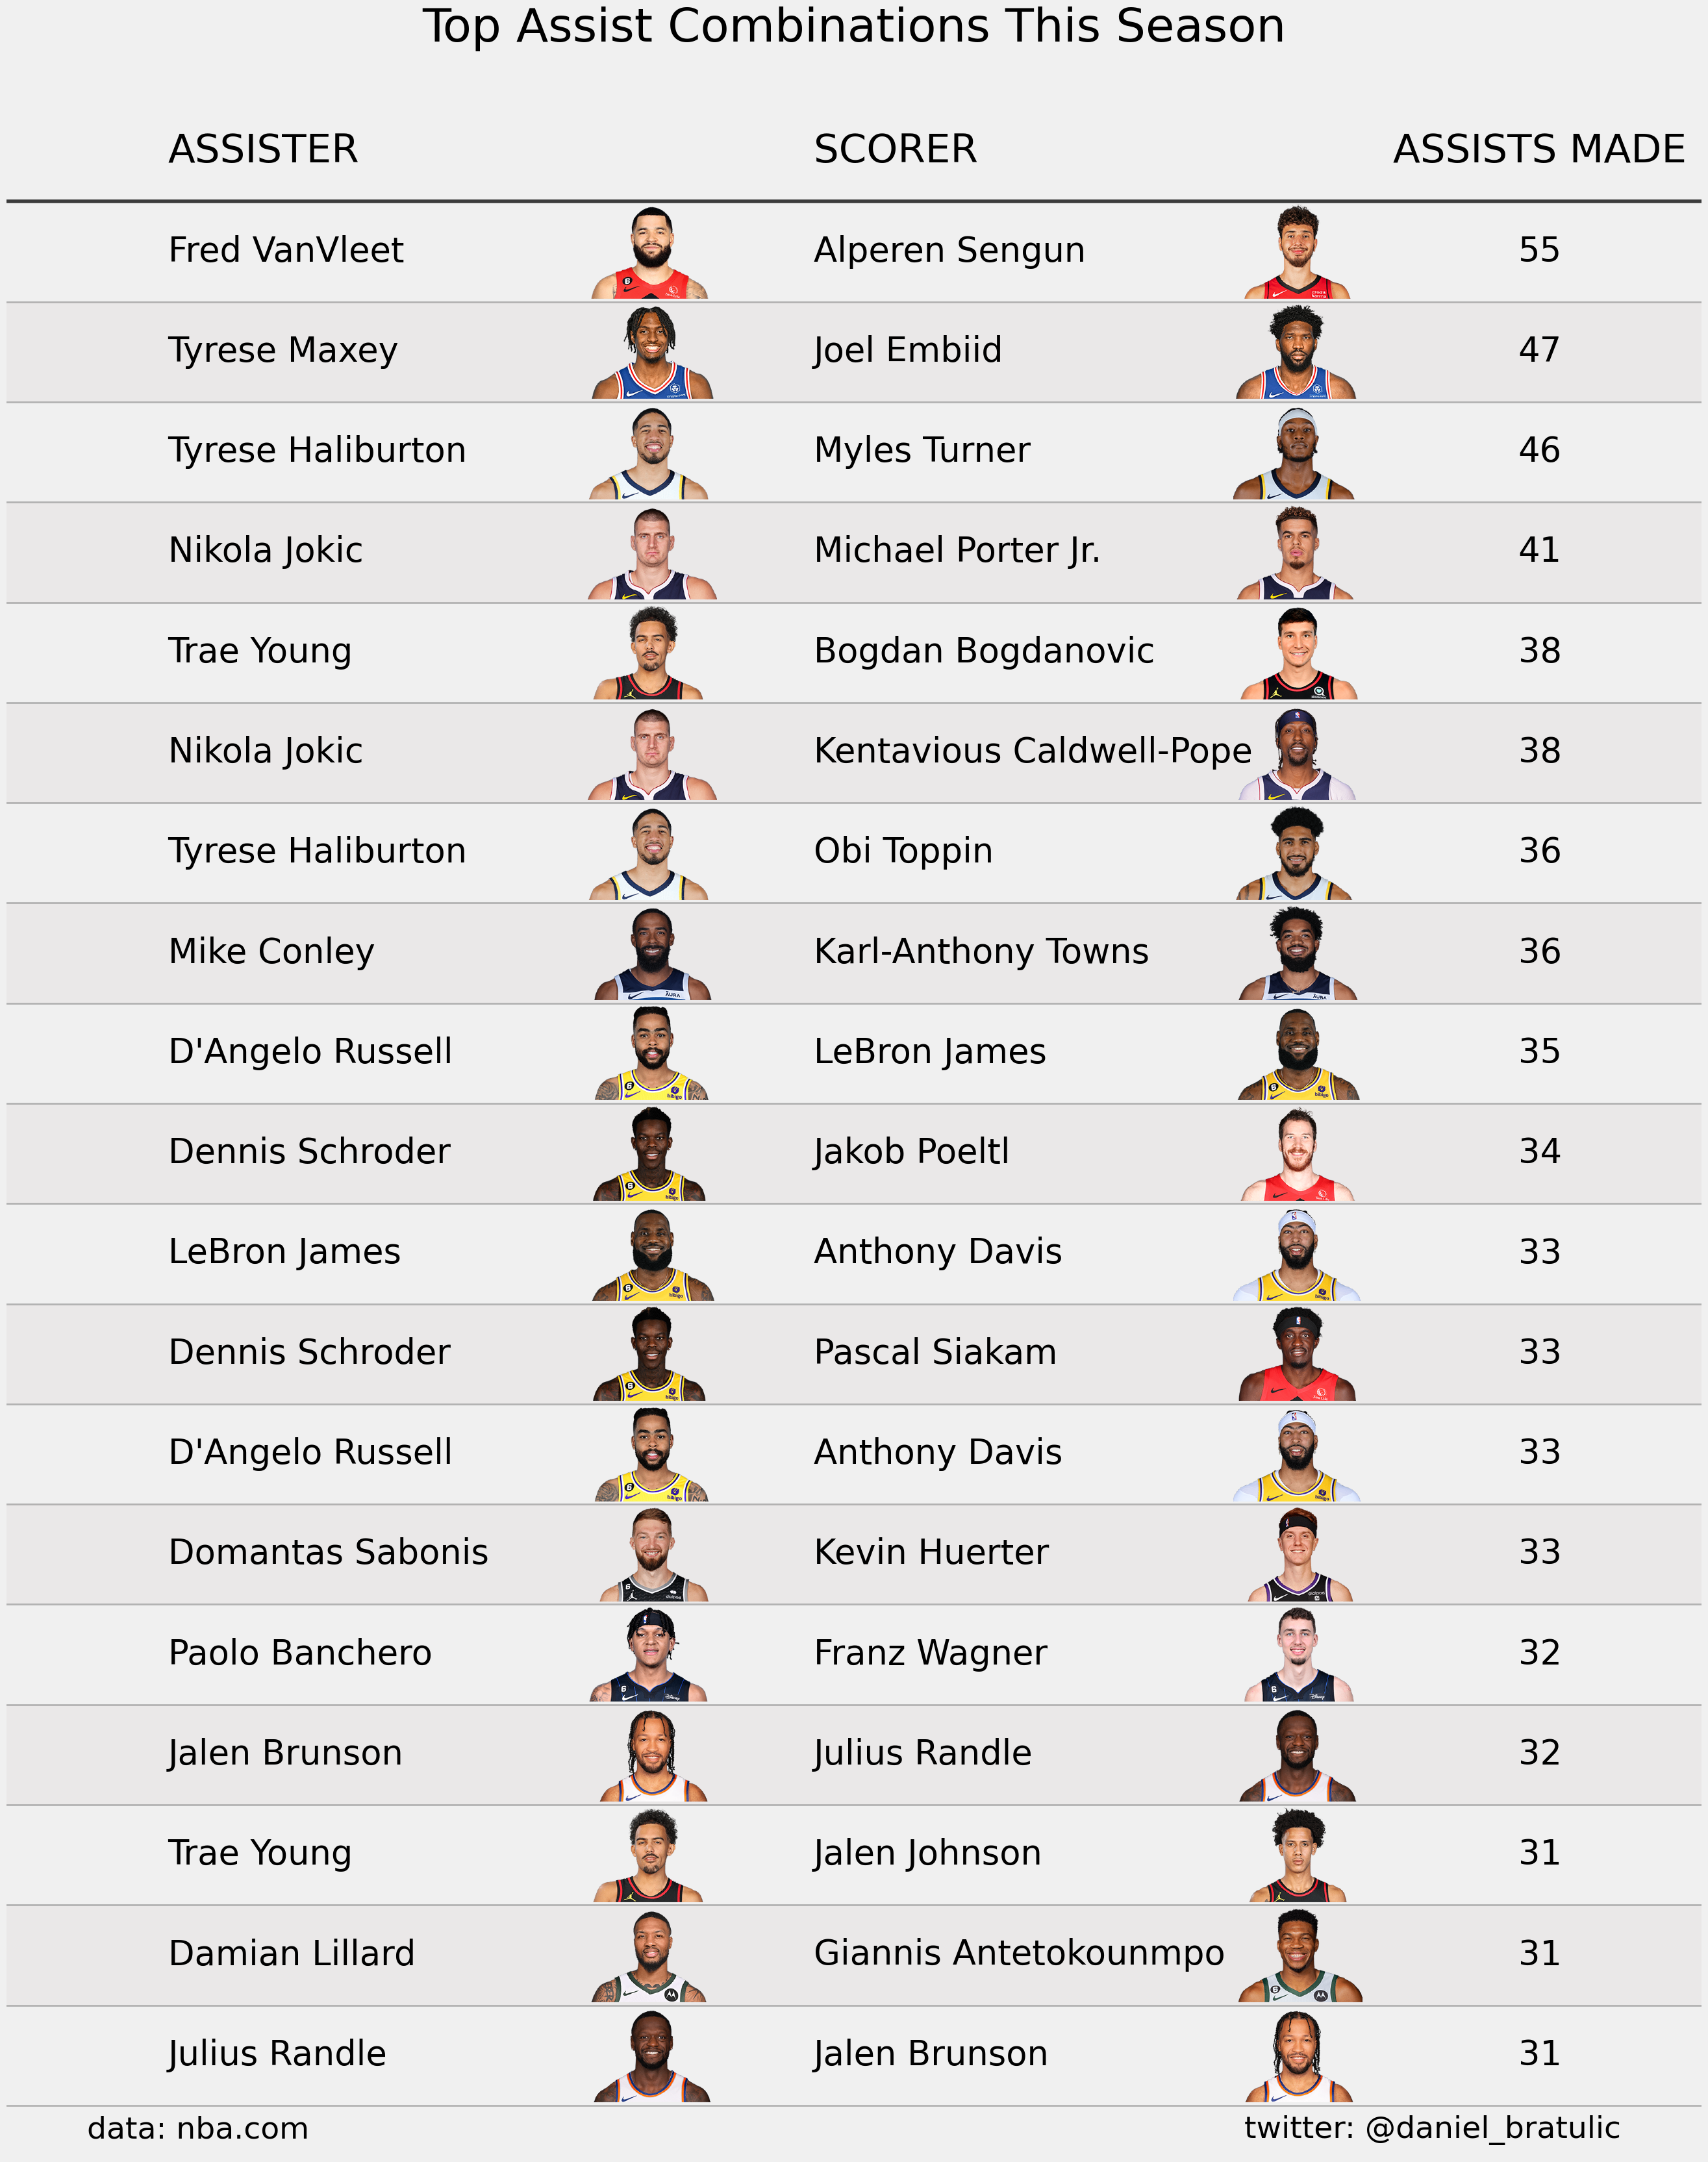

In [25]:
fig, ax = plt.subplots(figsize=(30, 40))
font_size = 38
font_title = 44
top = len(top_assist)
#top = 10


for i in range(top):
    item = top_assist.iloc[i]
    y_coord = top - i - 1
    if i % 2 == 1:
        color = '#EAE8E8'
        rect = Rectangle((-4.5, y_coord-0.5), width=15, height=1, fill=True, color=color)
        ax.add_patch(rect)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=10, color='#A0A0A0', alpha=0.75, lw=2)
    ab = AnnotationBbox(get_player_img(item.PLAYER2_ID, zoom=0.55), (0.4, y_coord), frameon=False)
    ax.add_artist(ab)
    ax.text(x=0.1, y=y_coord, ha='left', va='center', s=item.PLAYER2_NAME, size=font_size)
    
    ab = AnnotationBbox(get_player_img(item.PLAYER1_ID, zoom=0.55), (0.8, y_coord), frameon=False)
    ax.add_artist(ab)
    ax.text(x=0.5, y=y_coord, ha='left', va='center', s=item.PLAYER1_NAME, size=font_size)
    ax.text(x=0.95, y=y_coord, ha='center', va='center', s=f"{item.COUNT}", size=font_size)
    #ax.text(x=2.2, y=y_coord, ha='center', va='center', s=f"{item.OPP_WIDE_OPEN_FG3_PCT:.2f}%", size=font_size)
    #ax.text(x=2.7, y=y_coord, ha='center', va='center', s=f"{item.DIFF:.2f}%", size=font_size)
    

    #ax.imshow(player_imgs[item.PLAYER_ID], extent=(0, 0.3, y_coord-0.5,y_coord + 0.5), aspect='auto', zorder=1)
    #ax.imshow(team_imgs[item.TEAM_ID], extent=(0.27, 0.38, y_coord-0.5,y_coord + 0.5), aspect='auto', zorder=1)
    
    
    #y_img_start = y_coord-0.5 + (1 - 0.730769232) / 2
    #ax.imshow(img, extent=(0, 1.36, y_img_start-0.5, y_img_start + 0.1), aspect='auto')
    #ax.imshow(img, extent=(0, 260, 0, 190), aspect=260/190)
    
ax.text(x=0.1, y=top, s='ASSISTER', ha='left', va='center', size=font_title)
ax.text(x=0.5, y=top, ha='left', va='center', s="SCORER", size=font_title)
ax.text(x=0.95, y=top, ha='center', va='center', s="ASSISTS MADE", size=font_title)
#ax.text(x=2.7, y=top, ha='center', va='center', s="DIFF", size=font_title)

ax.text(x=1.0, y=-0.75, s='twitter: @daniel_bratulic', ha='right', va='center', size=34)
ax.text(x=0.05, y=-0.75, s='data: nba.com', ha='left', va='center', size=34)
ax.axhline(y=top-0.5, xmin=-0.25, xmax=10, color='black', alpha=0.75, lw=4)
ax.set_title("Top Assist Combinations This Season", size=52)
    
ax.set_ylim(bottom=-1, top=top+1)
ax.set_xlim(left=-0, right=1.05)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.savefig('table_assists.png', dpi=120, bbox_inches='tight')

In [33]:
from great_tables import sp500


In [35]:
# Define the start and end dates for the data range
start_date = "2010-06-07"
end_date = "2010-06-14"

In [36]:
sp500_mini = sp500[(sp500["date"] >= start_date) & (sp500["date"] <= end_date)]


In [39]:
sp500_mini.head()

date       open     high      low      close        volume  \
1398  2010-06-14  1095.0000  1105.91  1089.03  1089.6300  4.425830e+09   
1399  2010-06-11  1082.6500  1092.25  1077.12  1091.6000  4.059280e+09   
1400  2010-06-10  1058.7700  1087.85  1058.77  1086.8400  5.144780e+09   
1401  2010-06-09  1062.7500  1077.74  1052.25  1055.6899  5.983200e+09   
1402  2010-06-08  1050.8101  1063.15  1042.17  1062.0000  6.192750e+09   

      adj_close  
1398  1089.6300  
1399  1091.6000  
1400  1086.8400  
1401  1055.6899  
1402  1062.0000

In [38]:
top_assist.head()

index  PLAYER1_ID  PLAYER2_ID        PLAYER1_NAME       PLAYER2_NAME  COUNT
0   2551     1630578     1627832      Alperen Sengun      Fred VanVleet     55
1    643      203954     1630178         Joel Embiid       Tyrese Maxey     47
2    785     1626167     1630169        Myles Turner  Tyrese Haliburton     46
3   1486     1629008      203999  Michael Porter Jr.       Nikola Jokic     41
4    672      203992     1629027   Bogdan Bogdanovic         Trae Young     38

In [40]:
top_ast_subset = top_assist.loc[:, ['PLAYER1_NAME', 'PLAYER2_NAME', 'COUNT']]

In [45]:
(
    gt.GT(data=top_ast_subset).tab_header(title="Top Assist Combinations This Season").fmt_integer(columns=["COUNT"])
    .cols_label(
        PLAYER1_NAME="Assister",
        PLAYER2_NAME="Scorer",
        COUNT="Assists Made"
    )
)


C:\Python311\Lib\site-packages\great_tables\_tbl_data.py:169: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '55' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.iloc[row, col_indx] = value


GT(_tbl_data=                PLAYER1_NAME       PLAYER2_NAME  COUNT
0             Alperen Sengun      Fred VanVleet     55
1                Joel Embiid       Tyrese Maxey     47
2               Myles Turner  Tyrese Haliburton     46
3         Michael Porter Jr.       Nikola Jokic     41
4          Bogdan Bogdanovic         Trae Young     38
5   Kentavious Caldwell-Pope       Nikola Jokic     38
6                 Obi Toppin  Tyrese Haliburton     36
7         Karl-Anthony Towns        Mike Conley     36
8               LeBron James   D'Angelo Russell     35
9               Jakob Poeltl    Dennis Schroder     34
10             Anthony Davis       LeBron James     33
11             Pascal Siakam    Dennis Schroder     33
12             Anthony Davis   D'Angelo Russell     33
13             Kevin Huerter   Domantas Sabonis     33
14              Franz Wagner     Paolo Banchero     32
15             Julius Randle      Jalen Brunson     32
16             Jalen Johnson         Trae Young     31
17     Giannis Antetokounmpo     Damian Lillard     31
18             Jalen Brunson      Julius Randle     31, _body=<great_tables._gt_data.Body object at 0x000001D706911710>, _boxhead=Boxhead([ColInfo(var='PLAYER1_NAME', type=<ColInfoTypeEnum.default: 1>, column_label='Assister', column_align='left', column_width=None), ColInfo(var='PLAYER2_NAME', type=<ColInfoTypeEnum.default: 1>, column_label='Scorer', column_align='left', column_width=None), ColInfo(var='COUNT', type=<ColInfoTypeEnum.default: 1>, column_label='Assists Made', column_align='right', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=2, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=3, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=4, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=5, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=6, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=7, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=8, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=9, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=10, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=11, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=12, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=13, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=14, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=15, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=16, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=17, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=18, group_id=None, rowname=None, group_label=None, built=False)]), _row_groups=[], _group_rows=GroupRows([]), _spanners=Spanners([]), _heading=Heading(title='Top Assist Combinations This Season', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x000001D706912ED0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x000001D702B94D10>], _options=<great_tables._gt_data.Options object at 0x000001D706912890>, _has_built=False)

In [26]:
fb_assists = assists.loc[(assists.HOMEDESCRIPTION.str.contains('Running')) | (assists.VISITORDESCRIPTION.str.contains('Running'))]

In [27]:
fb_counts = fb_assists.groupby(['PLAYER1_ID', 'PLAYER2_ID', 'PLAYER1_NAME', 'PLAYER2_NAME']).size().to_frame().reset_index()

fb_counts = fb_counts.rename(columns={0: 'COUNT'})

fb_counts.sort_values(by='COUNT', ascending=False).reset_index().iloc[:30]

index  PLAYER1_ID  PLAYER2_ID       PLAYER1_NAME       PLAYER2_NAME  COUNT
0     654     1630167     1630169         Obi Toppin  Tyrese Haliburton     11
1       1        2544     1626156       LeBron James   D'Angelo Russell      8
2     821     1630552     1629027      Jalen Johnson         Trae Young      8
3    1011     1641709     1630595     Ausar Thompson    Cade Cunningham      8
4     195      203992     1629027  Bogdan Bogdanovic         Trae Young      8
5     311     1627783      203471      Pascal Siakam    Dennis Schroder      8
6      74      202695      201935      Kawhi Leonard       James Harden      7
7     316     1627783     1630567      Pascal Siakam     Scottie Barnes      7
8     688     1630178     1629001       Tyrese Maxey  De'Anthony Melton      7
9     213     1626145     1628398         Tyus Jones         Kyle Kuzma      7
10    752     1630228      101108   Jonathan Kuminga         Chris Paul      7
11    347     1628369     1628401       Jayson Tatum      Derrick White      7
12   1032     1641722     1630529     Jordan Hawkins      Herbert Jones      7
13    552     1629627     1630700    Zion Williamson      Dyson Daniels      6
14    375     1628384      203471         OG Anunoby    Dennis Schroder      6
15    216     1626156        2544   D'Angelo Russell       LeBron James      6
16     54      202331      201935        Paul George       James Harden      6
17    182      203954     1629001        Joel Embiid  De'Anthony Melton      6
18    155      203924     1627763       Jerami Grant    Malcolm Brogdon      6
19    301     1627759     1628401       Jaylen Brown      Derrick White      5
20    837     1630567      203471     Scottie Barnes    Dennis Schroder      5
21    499     1629022     1626220   Lonnie Walker IV      Royce O'Neale      5
22     11      201142     1628960       Kevin Durant      Grayson Allen      5
23    795     1630532     1631094       Franz Wagner     Paolo Banchero      5
24    439     1628971     1630169        Bruce Brown  Tyrese Haliburton      5
25    905     1631094     1630591     Paolo Banchero        Jalen Suggs      5
26    396     1628398     1630166         Kyle Kuzma        Deni Avdija      5
27    376     1628384     1627783         OG Anunoby      Pascal Siakam      5
28    391     1628398     1626145         Kyle Kuzma         Tyus Jones      5
29    469     1629001      203954  De'Anthony Melton        Joel Embiid      5

In [31]:
assists.loc[(assists.PLAYER2_NAME == 'Tyrese Haliburton') & (assists.PLAYER1_NAME == 'Obi Toppin')].HOMEDESCRIPTION.unique()

array(["Toppin 1' Cutting Layup Shot (7 PTS) (Haliburton 6 AST)",
       "Toppin 1' Cutting Layup Shot (9 PTS) (Haliburton 7 AST)",
       "Toppin 1' Alley Oop Dunk (11 PTS) (Haliburton 8 AST)",
       'Toppin Running Layup (13 PTS) (Haliburton 12 AST)',
       "Toppin 24' 3PT Jump Shot (16 PTS) (Haliburton 16 AST)", '',
       "Toppin 2' Running Layup (2 PTS) (Haliburton 3 AST)",
       "Toppin 3' Running Finger Roll Layup (6 PTS) (Haliburton 8 AST)",
       "Toppin 3' Running Reverse Layup (4 PTS) (Haliburton 5 AST)",
       "Toppin 3' Running Alley Oop Dunk Shot (6 PTS) (Haliburton 7 AST)",
       "Toppin 2' Driving Reverse Layup (2 PTS) (Haliburton 1 AST)",
       "Toppin 1' Running Alley Oop Layup Shot (2 PTS) (Haliburton 3 AST)",
       "Toppin 27' 3PT Running Jump Shot (6 PTS) (Haliburton 7 AST)",
       "Toppin 1' Cutting Dunk Shot (11 PTS) (Haliburton 8 AST)",
       "Toppin 25' 3PT Jump Shot (3 PTS) (Haliburton 2 AST)",
       "Toppin 1' Alley Oop Dunk (5 PTS) (Haliburton 7 A